In [1]:
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np

mesh = ngs.Mesh('proximity_geo.vol')
mesh.Curve(2)
# mesh.RefineHP(3,factor = 0.2)
mesh.Refine()

In [2]:
# Draw(mesh)

In [3]:
# H1 = ngs.H1(mesh, order = 2, dirichlet = "ambient_face")
# cfJ = mesh.MaterialCF({"circle": 1}, default = 0)

# u,v = H1.TnT()

# K = ngs.BilinearForm(H1)
# K += (ngs.grad(u)*ngs.grad(v))*ngs.dx()
# K.Assemble()

# f = ngs.LinearForm(H1)
# f += (cfJ*v)*ngs.dx()
# f.Assemble()

# x = ngs.GridFunction(H1)
# x.vec.data += K.mat.Inverse(H1.FreeDofs())*f.vec

# # Draw(x)
# # Draw(cfJ,mesh)

In [4]:
# Parameters

circ_mass = np.pi*0.031**2
circ_number = 58

mu0 = 1.256*1e-6
mu_iron = 1*mu0
sigma = 58*1e6
J = 1e7/(circ_mass)

circles_left = ""; 
for i in range(58): circles_left+="circle_left_"+str(i)+"|"
circles_right = ""; 
for i in range(58): circles_right+="circle_right_"+str(i)+"|"

cf_Js = mesh.MaterialCF({circles_left: J, circles_right: -J}, default = 0)
cf_mu = mesh.MaterialCF({ circles_left +circles_right +"left|right|bridge" : mu0, "ambient": mu_iron})
cf_sigma = mesh.MaterialCF({circles_left +circles_right: sigma}, default = 0)

f = 50 #(Hz)
w = f*2*np.pi

# H1 = ngs.H1(mesh, order = 2, dirichlet = "ambient_face")
H1 = ngs.H1(mesh, order = 3, dirichlet = "ambient_face", complex = True)
u,v = H1.TnT()

K = ngs.BilinearForm(H1)
K += (1/cf_mu*ngs.grad(u)*ngs.grad(v))*ngs.dx + ((1j*w)*sigma*u*v)*ngs.dx(circles_left +circles_right)
K.Assemble()

f = ngs.LinearForm(H1)
f += (cf_Js*v)*ngs.dx()
f.Assemble()


A = ngs.GridFunction(H1)
A.vec.data += K.mat.Inverse(H1.FreeDofs())*f.vec

B = ngs.grad(A)

J = (cf_Js -(1j*w)*cf_sigma*A)
intJ = ngs.Integrate(J, mesh)

# J = J/intJ*I

Draw(ngs.Norm(J), mesh, settings = {"Objects": {"Wireframe": False}})
Draw(ngs.Norm(B),mesh, settings = {"Objects": {"Wireframe": False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [5]:
ngs.Integrate(cf_Js, mesh)

-14996.737848308854

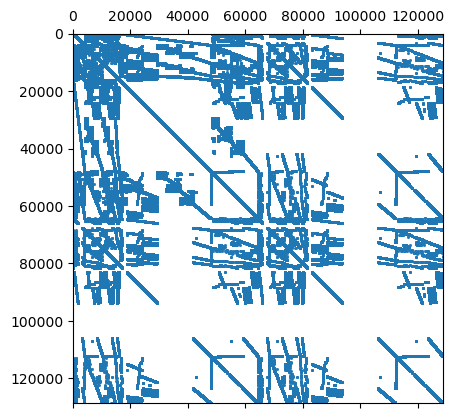

In [32]:
# Parameters

circ_mass = np.pi*0.031**2
circ_number = 58

mu0 = 1.256*1e-6
mu_iron = 100*mu0
sigma = 58*1e6
J = 1e7
eps = 1e-12
order = 2

circles_left = ""; 
for i in range(58): circles_left+="circle_left_"+str(i)+"|"
circles_right = ""; 
for i in range(58): circles_right+="circle_right_"+str(i)+"|"

cf_Js = mesh.MaterialCF({circles_left: J, circles_right: -J}, default = 0)
cf_mu = mesh.MaterialCF({ circles_left + circles_right +"left|right|bridge" : mu0, "ambient": mu_iron})
cf_sigma = mesh.MaterialCF({circles_left + circles_right: sigma}, default = 0)

#############################################################################################################

f = 50 #(Hz)
w = f*2*np.pi

H1 = ngs.H1(mesh, order = order, dirichlet = "ambient_face", complex = True)
PH1 = ngs.H1(mesh, order = order, dirichlet = "ambient_face", complex = True)

X = H1*PH1

# u,v = X.TnT()
(A,L), (As,Ls) = X.TnT()

K = ngs.BilinearForm(X)
K += (1/cf_mu*ngs.grad(A)*ngs.grad(As))*ngs.dx +((1j*w)*cf_sigma*(A+L)*As + 1/eps*ngs.grad(L)*ngs.grad(As))*ngs.dx(circles_left + circles_right)\
    +((1j*w)*cf_sigma*(A+L)*Ls + 1/eps*ngs.grad(L)*ngs.grad(Ls))*ngs.dx(circles_left + circles_right)
K.Assemble()

rows,cols,vals = K.mat.COO()
import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))
import matplotlib.pylab as plt
plt.spy(A, markersize = 1)


f = ngs.LinearForm(X)
f += (cf_Js*Ls)*ngs.dx(circles_left + circles_right)
# f += (cf_Js*v)*ngs.dx() + ((1-cf_Js)*q)*ngs.dx("circle_left|circle_right")
f.Assemble()


A_and_L = ngs.GridFunction(X)
A_and_L.vec.data += K.mat.Inverse(X.FreeDofs())*f.vec

A = A_and_L.components[0]
L = A_and_L.components[1]
B = ngs.grad(A)

####################################
# Post-Processing
####################################

# H1 = ngs.H1(mesh, order = order, complex = True)

# u,v = H1.TnT()
# K1 = ngs.BilinearForm(H1)
# K1 += u*v*ngs.dx(circles_left + circles_right)
# K1.Assemble()

# el = ngs.LinearForm(H1)
# el += 1/eps*ngs.grad(L)*ngs.grad(v)*ngs.dx(circles_left + circles_right)
# el.Assemble()

# liftL = ngs.GridFunction(H1)

# liftL.vec.data = K1.mat.Inverse(H1.FreeDofs())*el.vec

####################################


J = (1j*w)*cf_sigma*(A+L)


# # J = J/intJ*I

In [46]:
Draw(ngs.Norm(J), mesh, settings = {"Objects": {"Wireframe": False}}, order2d = 2)
Draw(ngs.Norm(J), mesh, settings = {"Objects": {"Wireframe": False}}, animate_complex = True)
Draw(ngs.Norm(B), mesh, settings = {"Objects": {"Wireframe": False}})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [8]:
int = []
for i in range(58):
    int.append(ngs.Integrate(J*ngs.dx("circle_left_"+str(i)), mesh))
for i in range(58):
    int.append(ngs.Integrate(J*ngs.dx("circle_right_"+str(i)), mesh))
# mesh.nv

plt.semilogy(abs(np.real(int)))
plt.figure()
plt.semilogy(abs(np.imag(int)))

# ngs.Integrate(1/eps*ngs.grad(L)*ngs.grad(A), mesh)

NameError: name 'plt' is not defined

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

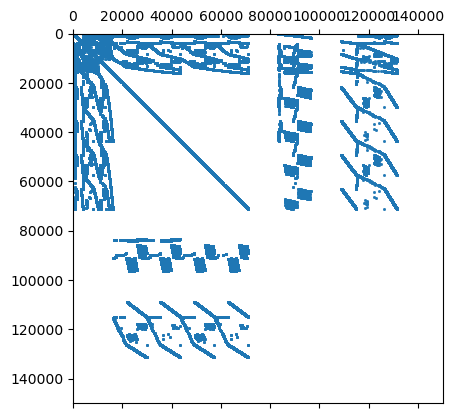

In [28]:
# Parameters

circ_mass = np.pi*0.031**2
circ_number = 58

mu0 = 1.256*1e-6
mu_iron = 1000*mu0
sigma = 58*1e6
J = 1e7
eps = 1e-12
order = 1

circles_left = ""; 
for i in range(58): circles_left+="circle_left_"+str(i)+"|"
circles_right = ""; 
for i in range(58): circles_right+="circle_right_"+str(i)+"|"

cf_Js = mesh.MaterialCF({circles_left: J, circles_right: -J}, default = 0)
cf_mu = mesh.MaterialCF({circles_left + circles_right +"left|right|bridge" : mu0, "ambient": mu_iron})
cf_sigma = mesh.MaterialCF({circles_left + circles_right: sigma}, default = 0)

#############################################################################################################

f = 50 #(Hz)
w = f*2*np.pi

order = 1

H1_A = ngs.H1(mesh, order = order, dirichlet = "ambient_face", complex = True)
L2_L = ngs.L2(mesh, order = order, complex = True, definedon = circles_left + circles_right)
HDiv_U = ngs.HDiv(mesh, order = order , complex = True, definedon = circles_left + circles_right, dirichlet = "ambient_face")


X = H1_A*L2_L*HDiv_U

(A,L,U), (As,Ls,Us) = X.TnT()

K = ngs.BilinearForm(X)
K += (1/cf_mu*ngs.grad(A)*ngs.grad(As))*ngs.dx +((1j*w)*cf_sigma*(A+L)*As +ngs.div(U)*As)*ngs.dx(circles_left + circles_right)\
    +((1j*w)*cf_sigma*(A*Ls + L*Ls) + ngs.div(U)*Ls)*ngs.dx(circles_left + circles_right)\
    +(L*ngs.div(Us))*ngs.dx(circles_left + circles_right)\
    
    # +(L*ngs.div(Us))*ngs.dx\
    # +((1j*w)*cf_sigma*p*v)*ngs.dx("circle_left|circle_right")\
    # +((1j*w)*cf_sigma*p*q)*ngs.dx("circle_left|circle_right")\
    # + 1/eps*p*q*ngs.dx("circle_left|circle_right")
K.Assemble()

rows,cols,vals = K.mat.COO()
import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))
import matplotlib.pylab as plt
plt.spy(A, markersize = 1)

f = ngs.LinearForm(X)
f += (cf_Js*Ls)*ngs.dx(circles_left + circles_right)
# f += (cf_Js*v)*ngs.dx() + ((1-cf_Js)*q)*ngs.dx("circle_left|circle_right")
f.Assemble()


ALU = ngs.GridFunction(X)
ALU.vec.data += K.mat.Inverse(X.FreeDofs())*f.vec

A = ALU.components[0]
L = ALU.components[1]
U = ALU.components[2]

B = ngs.grad(A)

J = (1j*w)*cf_sigma*(A+L)+ngs.div(U)

# # J = J/intJ*I

Draw(ngs.Norm(J), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw(L, mesh, settings = {"Objects": {"Wireframe": False}})
# Draw(ngs.Norm(B),mesh, settings = {"Objects": {"Wireframe": False}})

In [27]:
print(np.array(X.FreeDofs()).shape)
print(np.where(np.array(X.FreeDofs()))[0].shape)

(149960,)
(87565,)
